# Training Facial Expression CNN Using Tensor Flow

## Importing modules and initial data sets 
####  (source: https://www.kaggle.com/datasets/debanga/facial-expression-recognition-challenge)

In [5]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from tensorflow.keras.layers import  Conv2D
from tensorflow.keras.layers import  MaxPooling2D,AveragePooling2D
from tensorflow.keras.layers import  Dense
from tensorflow.keras import datasets
from tensorflow.keras import models, layers
from tensorflow.keras import optimizers


From source above this is how the emotion codes correlate to the emotions

In [6]:
emotion_dict = {0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"}

In [7]:
#test_df = pd.read_csv(r"C:\Users\matt8\Downloads\faceset1\test.csv")

In [8]:
#test_df

In [9]:
df = pd.read_csv(r"C:\Users\matt8\Downloads\faceset1\icml_face_data.csv")

In [10]:
df = df.drop(" Usage",axis=1).copy()

In [11]:
df

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


# 

## Converting pixel data into usable form that TF (tensorflow) will like

In [12]:
df.columns = ["emotion","pixels"]

The pixel information from the source comes as a string of numbers of 1, 2, or 3 digits - from 0 to 255 (incl) separated by spaces. Following cell takes that string for each image and converts into a numpy array. The datatype np.uint16 is the most efficient way to encode these values.

In [13]:
df["pixels_list"] = df.pixels.map(lambda x: np.fromstring(x, dtype=np.uint16, sep=' '))

Functions to retrieve the dimensions of the image dataframes. First one checks the number of numbers in the pixel string, ensures that all images in the data set have the same dimensions, and that there are a square number of number - then returns the (positive) root of this number. Second one just returns the number of images in that dataframe

In [14]:
def image_dimension(data_frame):
    pxls = data_frame.pixels_list.apply(len)
    if pxls.isin(np.array(pxls)).all() != True:
        return "Image pixelation is not consistent across images"
    else:
        length = np.array(pxls,dtype =np.uint16)[0]
        dim = math.sqrt(length)
        if dim%1 == 0:
            return int(dim)
        else:
            return "Image pixelation has not produced a square image"
        
def number_of_images(data_frame):
    return len(data_frame.index)

inp_dim (input dimensions) should not change throughout this workbook - in theory this allows for a different dataframe to be inputted and the model to still work although some manipulation will be required on the dataframe first.

In [15]:
inp_dim = image_dimension(df)
num_dim = number_of_images(df)

After defining inp_dim it can be used to reshape the lists/np.arrays of pixels into matrices to reflect the square nature of the images and to make formatting in TF easier later on

In [16]:
pixels_mat =  df.pixels_list.apply(lambda x : x.reshape(inp_dim,inp_dim))

In [17]:
df["pixels_mat"] = pixels_mat


Final version of intial dataframe:

In [18]:
df

,emotion,pixels,pixels_list,pixels_mat
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...","[[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, ..."
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ...","[[151, 150, 147, 155, 148, 133, 111, 140, 170,..."
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ...","[[231, 212, 156, 164, 174, 138, 161, 173, 182,..."
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2...","[[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, ..."
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...","[[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 2..."
...,...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,"[50, 36, 17, 22, 23, 29, 33, 39, 34, 37, 37, 3...","[[50, 36, 17, 22, 23, 29, 33, 39, 34, 37, 37, ..."
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,"[178, 174, 172, 173, 181, 188, 191, 194, 196, ...","[[178, 174, 172, 173, 181, 188, 191, 194, 196,..."
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,"[17, 17, 16, 23, 28, 22, 19, 17, 25, 26, 20, 2...","[[17, 17, 16, 23, 28, 22, 19, 17, 25, 26, 20, ..."
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,"[30, 28, 28, 29, 31, 30, 42, 68, 79, 81, 77, 6...","[[30, 28, 28, 29, 31, 30, 42, 68, 79, 81, 77, ..."


Despite the seemingly messy way of storing a list and matrix in each row the dataframe does take up very little memory space so is fast and efficient to work with currently.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   emotion      35887 non-null  int64 
 1   pixels       35887 non-null  object
 2   pixels_list  35887 non-null  object
 3   pixels_mat   35887 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.1+ MB


In [21]:
df.to_pickle("TFdf1.pkl")

# 

## Creating a different representation of the dataframe where each pixel value gets its own column entry for each image

Casting the list of pixels into one value per column and then forming a dataframe from this:

In [10]:
#df0 = pd.DataFrame( df.pixels_list.tolist())

In [12]:
#df0["emotion"] = df.emotion

In [13]:
#l = ["pixel_"+str(i) for i in range(len(df0.columns)-1)]

In [14]:
#l.append("emotion")

In [15]:
#df0.columns = l

Below is alternate view of data, tidier in a way - more atomic - but considerably more memory intensive and more unwieldly, will probably be dropped later on

In [16]:
#df0

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_2295,pixel_2296,pixel_2297,pixel_2298,pixel_2299,pixel_2300,pixel_2301,pixel_2302,pixel_2303,emotion
0,70,80,82,72,58,58,60,63,54,58,...,182,183,136,106,116,95,106,109,82,0
1,151,150,147,155,148,133,111,140,170,174,...,108,95,108,102,67,171,193,183,184,0
2,231,212,156,164,174,138,161,173,182,200,...,138,152,122,114,101,97,88,110,152,2
3,24,32,36,30,32,23,19,20,30,41,...,126,132,132,133,136,139,142,143,142,4
4,4,0,0,0,0,0,0,0,0,0,...,34,31,31,31,27,31,30,29,30,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35882,50,36,17,22,23,29,33,39,34,37,...,215,216,217,221,222,220,223,221,216,6
35883,178,174,172,173,181,188,191,194,196,199,...,141,136,118,66,7,0,0,0,0,3
35884,17,17,16,23,28,22,19,17,25,26,...,179,193,193,194,170,148,154,133,113,0
35885,30,28,28,29,31,30,42,68,79,81,...,27,27,26,28,35,35,35,30,28,3


In [11]:
#df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Columns: 2304 entries, 0 to 2303
dtypes: int16(2304)
memory usage: 157.7 MB


# 

## Shuffling data sets for testing and training

First function splits above dataframe (either representation) into training and testing sets. Standard convention is 80% train and 20% test - this is reflected in arguments. The random argument is an attempt to mimic SK Learns train_test_split function which allows a fixed state of randomness - here fixed state of randomness occurs with random == False and will shuffle the data based on a random seed generated from the number of images in the data, if random is True then each time function is called on the dataframe the shuffling and partitioning into training and testing sets in different. 

In order to separate labels and data the emotion column is dropped from the training and testing datasets.

In [16]:
def random_sample(data_frame,random,train_perc = 0.8,test_perc=0.2):
    ind = np.array(data_frame.index)
    entries = len(ind)
    rand_Seed = np.random.randint(0,entries)
    fixed_Seed = entries
    train_num = round(entries*train_perc)
    if random == True:  
        rng = np.random.default_rng(rand_Seed)
        shuff = rng.choice(ind,size = entries,replace = False)
        train_sample = data_frame.iloc[shuff][:train_num]
        train_labels = data_frame.iloc[shuff].emotion[:train_num]
        test_sample = data_frame.iloc[shuff][train_num:]
        test_labels = data_frame.iloc[shuff].emotion[train_num:]
    elif random == False:
        rng = np.random.default_rng(fixed_Seed)
        shuff = rng.choice(ind,size = entries,replace = False)
        train_sample = data_frame.iloc[shuff][:train_num]
        test_sample = data_frame.iloc[shuff][train_num:]
        train_labels = data_frame.iloc[shuff].emotion[:train_num]
        test_labels = data_frame.iloc[shuff].emotion[train_num:]
    return train_sample.drop("emotion",axis = 1),test_sample.drop("emotion",axis = 1),train_labels,test_labels

---

### Formatting different groups

Applying random_sample function on our source data in order to produce our 4 data sets required. Random = False is chosen so that patterns remain consistent during development and minimal changes occur.

In [29]:
train_df,test_df,train_labels,test_labels = random_sample(df,True)

Test to see if function has been applied correctly and shuffling has worked properly for all sets, should return (true,true) otherwise above function is broken.

In [30]:
(train_labels.index ==  train_df.index).all(),(test_labels.index ==  test_df.index).all()

(True, True)

Checking no data is lost and nominal 80:20 train:test split rounding hasn't gone wrong

In [31]:
number_of_images(df) ==  number_of_images(train_df) + number_of_images(test_df)

True

Variable inp_dim should not have changed from above but recalling it anyway, and introducing the number of images in train and test sets

In [32]:
inp_dim= image_dimension(train_df)
num_dim_X_train = number_of_images(train_df)
num_dim_X_test = number_of_images(test_df)

In [33]:
num_dim_X_test,num_dim_X_train, inp_dim

(7177, 28710, 48)

---

#### Defining training and testing data in TF friendly form - final version

---

Division by 255 on X sets is to normalise pixel values s.t. they exist on [0,1]. Improves CNN efficiency

In [34]:
X_train = np.stack(train_df.pixels_mat).reshape(num_dim_X_train, inp_dim, inp_dim,1)/255

In [35]:
Y_train = train_labels.values.reshape(num_dim_X_train,1)

In [36]:
X_test = np.stack(test_df.pixels_mat).reshape(num_dim_X_test, inp_dim, inp_dim,1)/255

In [37]:
Y_test = test_labels.values.reshape(num_dim_X_test,1)

---

---

#### Unfortunately there is a class imbalance in the dataset - this will make training harder and some provision will need to be made for this.

In training data:

In [38]:
pd.value_counts(np.ravel(Y_train)).iloc[np.argsort(pd.value_counts(np.ravel(Y_train)).index)]

0    3937
1     447
2    4095
3    7181
4    4909
5    3185
6    4956
dtype: int64

In testing data:

In [39]:
pd.value_counts(np.ravel(Y_test)).iloc[np.argsort(pd.value_counts(np.ravel(Y_test)).index)]

0    1016
1     100
2    1026
3    1808
4    1168
5     817
6    1242
dtype: int64

# 

## Visualising first 10 images in training set to check labels are correct

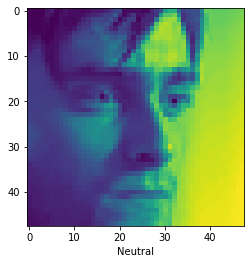

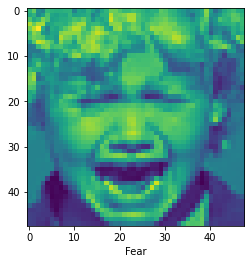

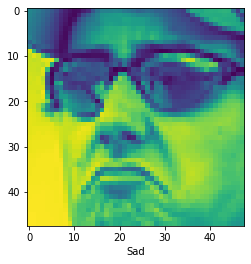

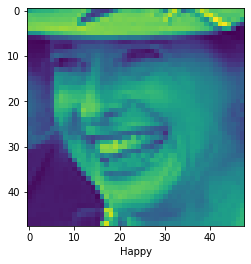

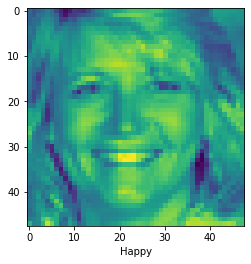

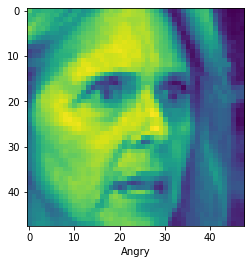

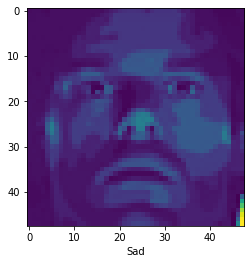

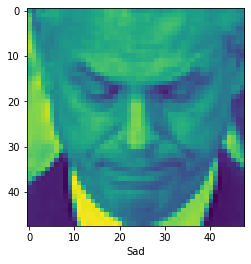

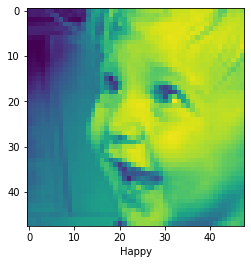

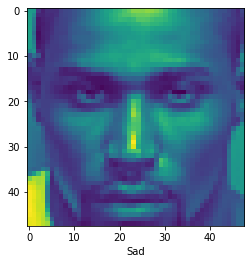

In [51]:
for i in range(10):    
    img_1 = train_df.iloc[i].pixels_mat/255
    text = train_labels.map(emotion_dict).iloc[i]
    plt.figure()
    plt.imshow(img_1)
    plt.grid(False)
    plt.xlabel(text)
    plt.show()

# 

## Using TF to create CNN model

In [41]:
InputShape = list(X_train.shape)
InputShape = np.array(InputShape)

In [42]:
InputShape

array([28710,    48,    48,     1])

In [43]:
def gen_model(train_data,labels):
    count_end = len(pd.unique(np.ravel(labels)))
    model = tf.keras.Sequential()
    model.add(Conv2D(16,(8,8),activation = "relu",input_shape = InputShape[1:]))
    model.add(AveragePooling2D(2,2))
    model.add(Conv2D(32,(6,6),activation = "relu"))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(64,(4,4),activation = "relu"))
    model.add(MaxPooling2D(2,2))
    #model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    # flattens the image array for final neurons, needs to come before dense layer
    model.add(layers.Flatten())
    model.add(Dense(128,activation="relu",kernel_initializer="he_normal"))
    #model.add(Dense(64,activation="relu", kernel_initializer="he_normal"))
    #model.add(Dense(32,activation="relu", kernel_initializer="he_normal"))

    model.add(Dense(count_end, activation="softmax"))
    return model

In [44]:
def config_model(model,logits=True):
    model.compile(optimizer= optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=logits),
              metrics=['accuracy'])
    return model

In [45]:
def fit_model(train_data,train_targets,test_data,test_targets,epoch_iterations,model):
    model = model.fit(x = train_data,y= train_targets,epochs= epoch_iterations,
                     validation_data=(test_data, test_targets))
    return model   

In [46]:
ml = gen_model(X_train,Y_train)

In [47]:
ml = config_model(ml,False)

In [48]:
ml.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 41, 41, 16)        1040      
                                                                 
 average_pooling2d (AverageP  (None, 20, 20, 16)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 32)        18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 32)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 64)         0

In [49]:
fit_ml = fit_model(X_train,Y_train,X_test,Y_test,5,ml)

Epoch 1/5
898/898 [==============================] - 45s 48ms/step - loss: 1.7494 - accuracy: 0.2924 - val_loss: 1.6182 - val_accuracy: 0.3690
Epoch 2/5
898/898 [==============================] - 48s 54ms/step - loss: 1.5692 - accuracy: 0.3864 - val_loss: 1.5373 - val_accuracy: 0.4042
Epoch 3/5
898/898 [==============================] - 64s 72ms/step - loss: 1.4847 - accuracy: 0.4232 - val_loss: 1.4801 - val_accuracy: 0.4283
Epoch 4/5
898/898 [==============================] - 63s 70ms/step - loss: 1.4247 - accuracy: 0.4497 - val_loss: 1.4392 - val_accuracy: 0.4468
Epoch 5/5
898/898 [==============================] - 58s 64ms/step - loss: 1.3736 - accuracy: 0.4726 - val_loss: 1.4249 - val_accuracy: 0.4491


In [50]:
# with kernel_int as he normal get ~25% accuracy, much lower without

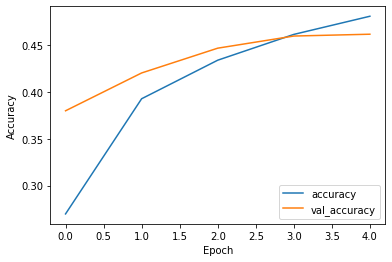

In [628]:
plt.plot(fit_ml.history['accuracy'], label='accuracy')
plt.plot(fit_ml.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0, 1])
plt.legend(loc='lower right')